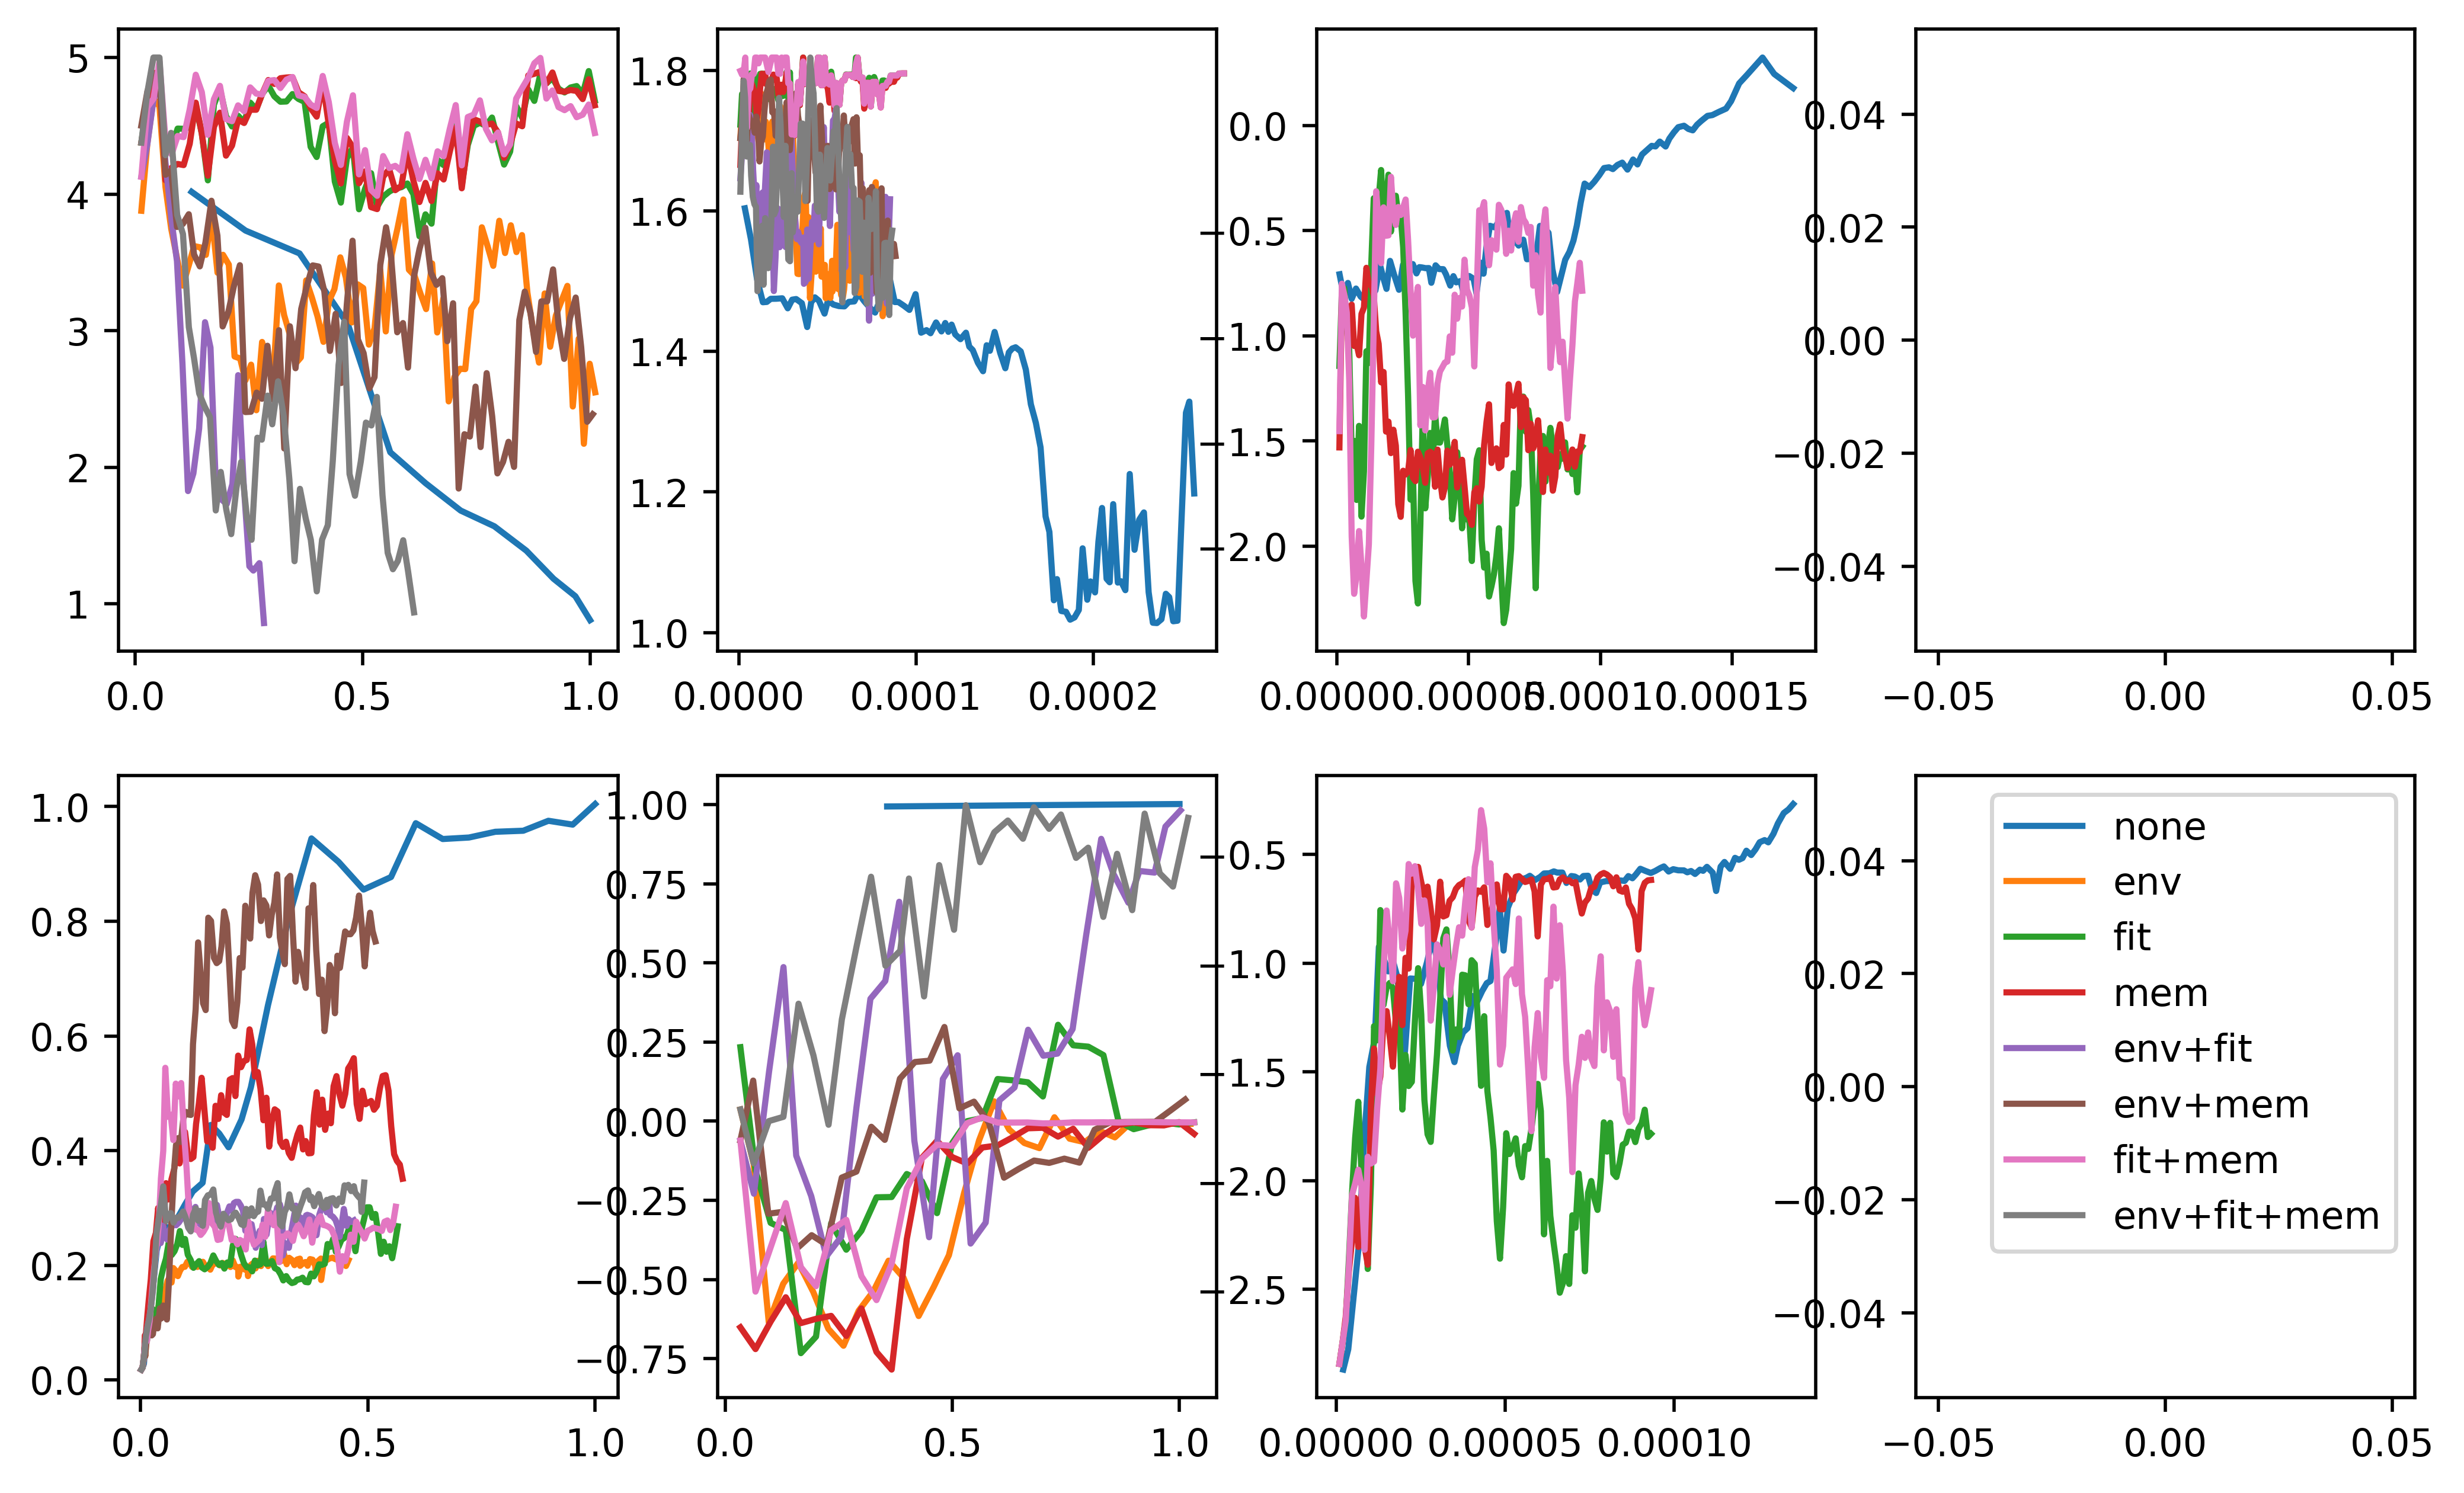

In [1]:
import os
import pickle

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42

font = {"family": "sans-serif", "weight": "normal", "size": 9.2}
matplotlib.rc("font", **font)

plt.rc("figure", figsize=[10, 6])
plt.rc("figure", titlesize=20)
plt.rc("axes", labelsize=15)
plt.rc("axes", titlesize=15)

base_path = "../../../data/outputs/agent/"

MAX_INT = 2**31 - 1

fig, axs = plt.subplots(2, 4, dpi=500)

evaluations = np.empty((8, 8, 1000, 2))
evaluations[:] = np.nan

score_thresholds = {
    "acrobot": -100,
    "cart_pole": 475,
    "mountain_car": -110,
    "mountain_car_continuous": 90,
    "lunar_lander": 200,
    "lunar_lander_continuous": 200,
    "mean": 1,
    "legend": 1,
}

steps_thresholds = {
    "acrobot": MAX_INT,
    "cart_pole": MAX_INT,
    "mountain_car": MAX_INT,
    "mountain_car_continuous": MAX_INT,
    "lunar_lander": MAX_INT,
    "lunar_lander_continuous": MAX_INT,
    "mean": MAX_INT,
    "legend": MAX_INT,
}


for i, env in enumerate(
    [
        "acrobot",
        "cart_pole",
        "mountain_car",
        "mountain_car_continuous",
        "lunar_lander",
        "lunar_lander_continuous",
        "mean",
        "legend",
    ]
):

    for j, transfer in enumerate(
        ["none", "env", "fit", "mem", "env+fit", "env+mem", "fit+mem", "env+fit+mem"]
    ):

        run_num_steps = 0 if transfer == "none" else 50

        for k, gen in enumerate(np.arange(1, 10001).tolist()):

            file_path = (
                base_path
                + f"env.{env}~paradigm.reinforcement/" + \
                f"agent-mode.neuroevolution~algorithm.ga~" + \
                f"pop_size.40~net_type.dynamic~gen_transfer.{transfer}~" + \
                f"run_num_steps.{run_num_steps}~pop_merge.False/" + \
                f"autoencoder-none/autoregressor-none/{gen}/evaluation.pkl"
            )
            
            if os.path.isfile(file_path):
                
                with open(file_path, "rb") as f:
                    scores, total_num_env_steps = pickle.load(f)

                mean_score = scores.mean()

                evaluations[i, j, k] = [mean_score, total_num_env_steps]

                if mean_score >= score_thresholds[env]:

                    if transfer == "none":

                        steps_thresholds[env] = total_num_env_steps

                    break

                if (
                    steps_thresholds[env] != None
                    and total_num_env_steps >= steps_thresholds[env]
                ):

                    break

        axs[i % 2][i // 2].plot(
            evaluations[i, j, :, 1] / steps_thresholds[env],
            evaluations[i, j, :, 0] / score_thresholds[env],
            label=transfer,
        )

plt.legend()